# Step0 - Import Libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_selection import mutual_info_regression,f_regression
from sklearn.base import TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler,RobustScaler
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score,roc_auc_score

import matplotlib.pyplot as plt
% matplotlib inline

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings("ignore")

print("Imports Loaded!")

Imports Loaded!


# Step1 - Exploration and Preparation


### Identify and mark continuous and categorical columns

In [2]:
seed= 0
rng=np.random.seed(seed)
NanCols={'job':['unemployed','unknown'],
        'marital_status':['unknown'],
        'credit_default':['unknown'],
        'housing':['unknown'],
        'loan':['unknown']}

Continuous_cols=['emp_var_rate','cons_price_idx','cons_conf_idx','euribor3m',
                 'nr_employed',"campaign","prev_contacts"]
columnsToDrop = []

### Declare and define functions that will be used further for processing

Here we have also included other function that we believed were necessary not only for plotting but analysing impact of adding features,how they were related etc.



In [3]:
def getData(file):
    df = pd.read_csv(file,header=0)
    df['subscribed']=df['subscribed'].replace('yes',1,regex=True)
    df['subscribed']=df['subscribed'].replace('no',0,regex=True)
    
    df['education']=df['education'].replace('basic.4y',"basic",regex=True)
    df['education']=df['education'].replace('basic.6y',"basic",regex=True)
    df['education']=df['education'].replace('basic.9y',"basic",regex=True)
    df["campaign"].ix[df["campaign"]>15]=15
    df["prev_contacts"].ix[df["prev_contacts"]>5]=5
    
    del df['duration']
    return df

def tagMissingValues(df):
    '''replace NAN vals'''
    train=df.copy()
    for key, value in NanCols.items():
        for val in value:
            train[key].ix[df[key]==val]="TAG"
    train = train.dropna(subset = columnsToDrop)
    return train
  
def splitTargetAndPredictors(df,targetColumn):
    '''seperate the response variable'''
    targetDf=pd.DataFrame(df[targetColumn])
    del df[targetColumn]
    return df,targetDf

def binColumns(df,threshold = 10):
    prevbins = [0, threshold,2*threshold,3*threshold]
    x = np.array(df.prev_days)
    df.prev_days = (np.digitize(x,prevbins)).astype(object)
    
    ageBins = [21,62,81]
    x = np.array(df.age)
    df.age = (np.digitize(x,ageBins)).astype(object)
    
    emplBins = np.arange(5000,5250,50)
    x = np.array(df.nr_employed)
    df.nr_employed=np.digitize(x,emplBins).astype(object)
    return df
    
def addFeatures(df):
    df.loc[(df['month']=='mar')|(df['month']=='apr')|(df['month']=='may'),"season"]="spring"
    df.loc[(df['month']=='jun')|(df['month']=='jul')|(df['month']=='aug'),"season"]="summer"
    df.loc[(df['month']=='sep')|(df['month']=='oct')|(df['month']=='nov'),"season"]="fall"
    df.loc[(df['month']=='dec')|(df['month']=='jan')|(df['month']=='feb'),"season"]="winter"
    return df

def Plot(cat = "category"):
    if cat == "category":
        fig_size = plt.rcParams["figure.figsize"]
        fig_size[0] = 10
        fig_size[1] = 4

        cols = [col for col in trainDataPrevDaysBinned.columns if col 
                not in Continuous_cols and col!="subscribed"]
        for col in cols:
            ptl = trainDataPrevDaysBinned.groupby([col])['subscribed'].mean()
            ptl = pd.DataFrame(ptl,index=trainDataPrevDaysBinned[col].unique())
            ptl = ptl.sort("subscribed")
            ptl.plot.barh()
            plt.title(col+ " vs subscribed")
    else:
        fig_size = plt.rcParams["figure.figsize"]
        fig_size[0] = 10
        fig_size[1] = 4

        cols = [col for col in trainDataPrevDaysBinned.columns if col in 
                Continuous_cols and col!="subscribed"]

        for col in cols:
            ptl = trainDataPrevDaysBinned.groupby([col])['subscribed'].mean()
            ptl = pd.DataFrame(ptl)
            ptl.plot(color='r')
            if col == "campaign":
                plt.xticks(np.arange(0,16,2))
            plt.title(col+ " vs subscribed")
    return None

### PLOTS

Here we have done analysis on missing values,how they could behave as a category by themselves or effect of imputing them.Note that this was necessary to understand the relationship of one feature with target.For the purpose of plots,we taggesd yes/no in subscribed  as 1/0 and are plotting mean values.

In [4]:
rawDf=getData("data/data.csv")
trainData=tagMissingValues(rawDf)
trainData=addFeatures(trainData)
trainDataPrevDaysBinned=binColumns(trainData)
trainX,trainY=splitTargetAndPredictors(trainDataPrevDaysBinned.copy(),'subscribed')


### Plots for categorical columns

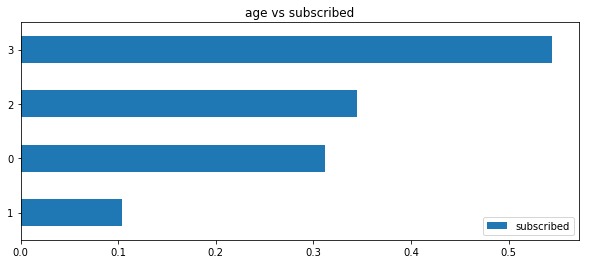

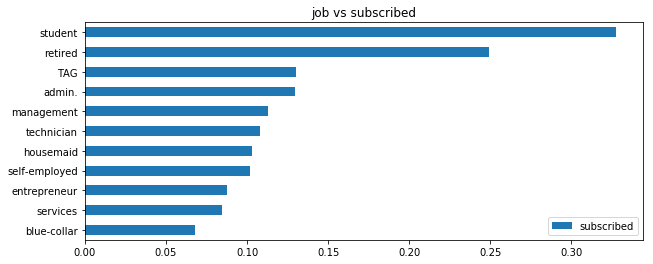

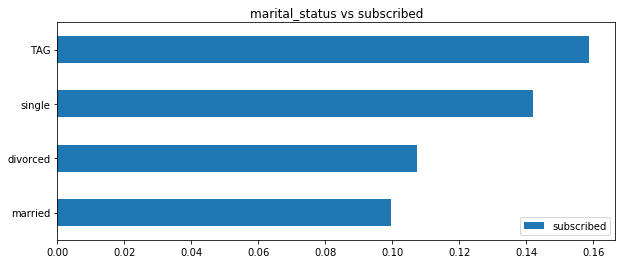

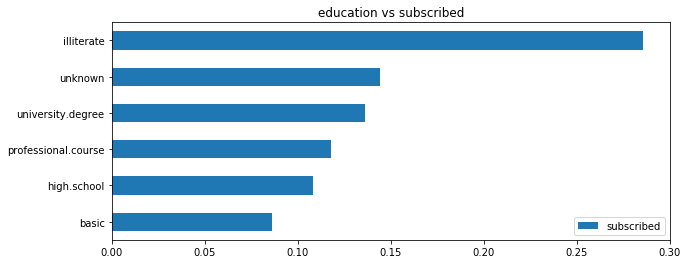

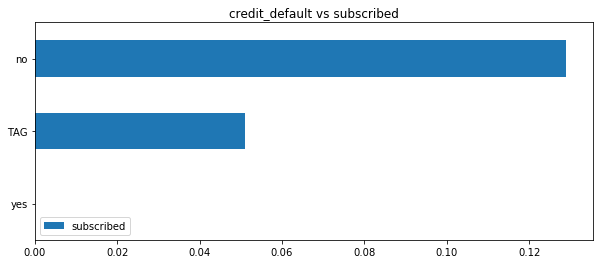

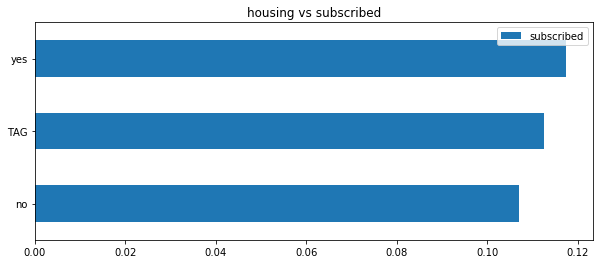

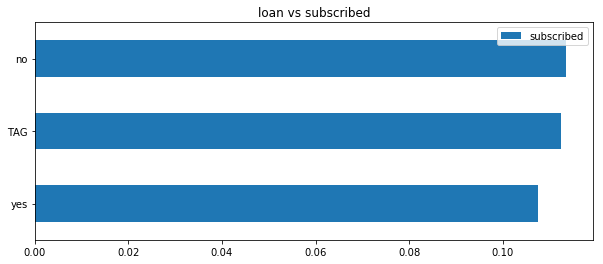

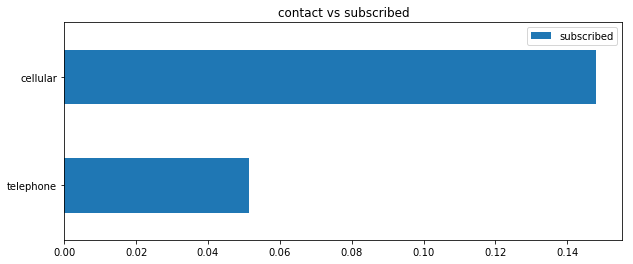

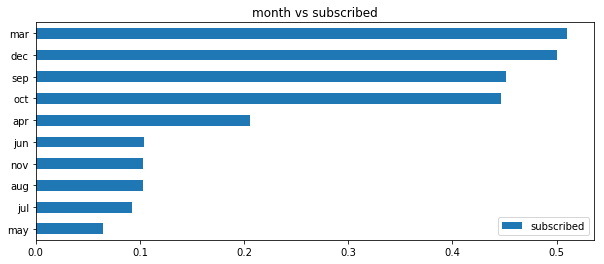

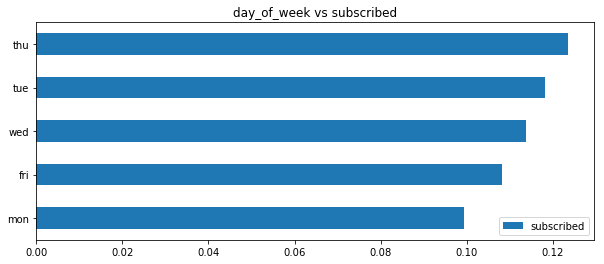

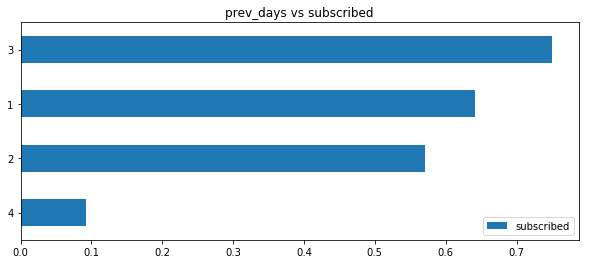

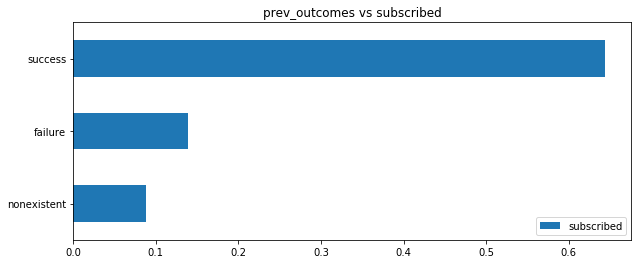

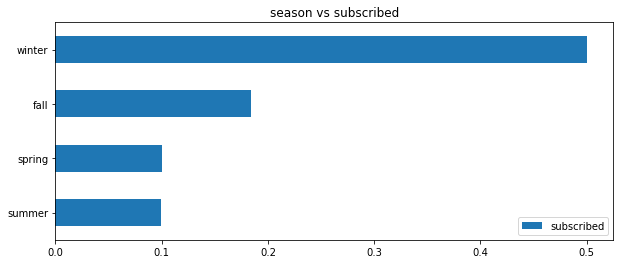

In [5]:
##plot categorical data
Plot()

### Plots for continuous columns

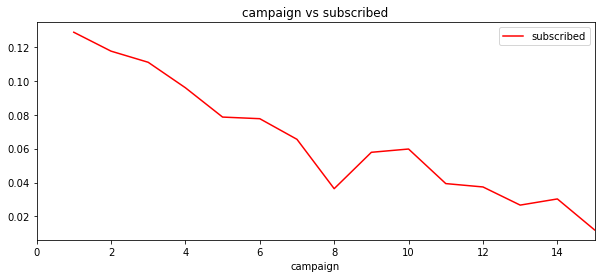

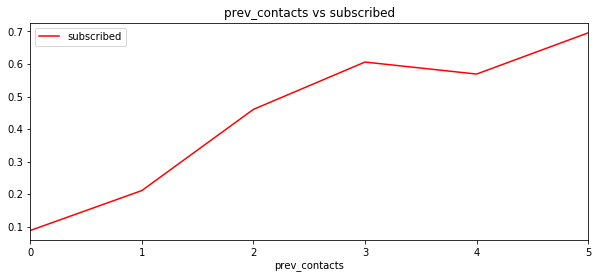

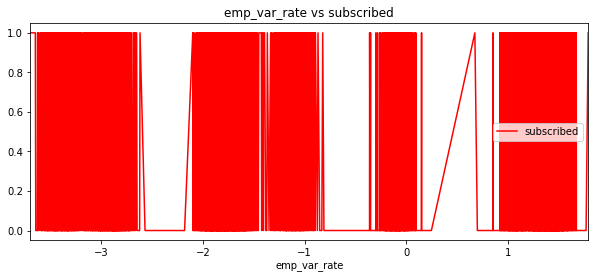

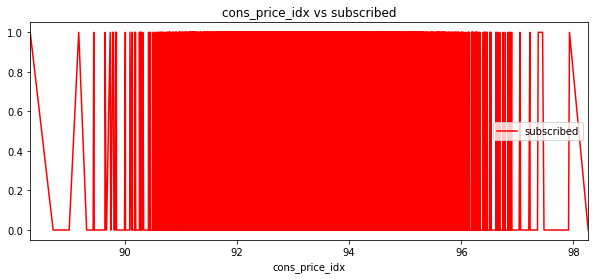

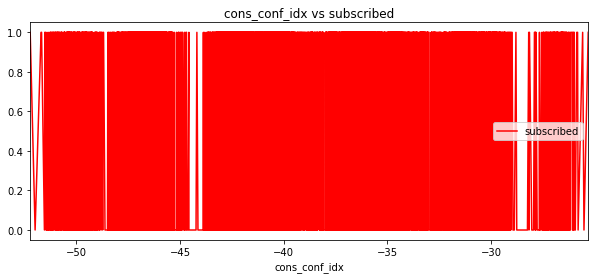

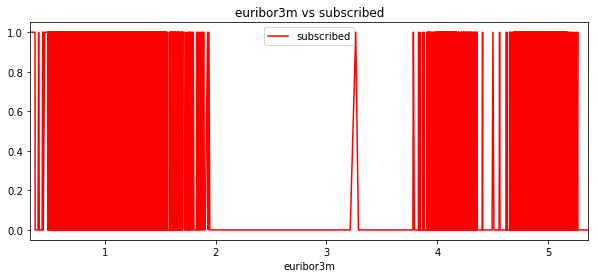

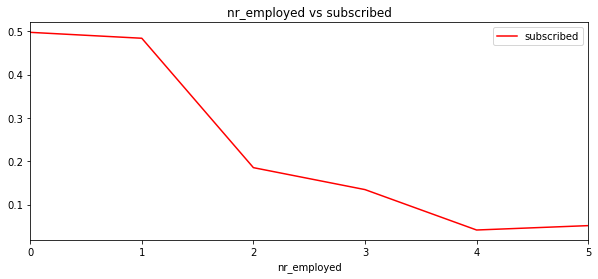

In [6]:
##plot continuous data
Plot("ncat")

# Step2 - ModelSet1 

### Feature Engineering

1) Drop duration feature from use

2) We found out after multiple trials and error that unknown themselves behave as category.Hence we attempted to learn model parameters with and without imputing them.

3) Also we tried derived new features from existing features-such as attaching season from months after learning relatship shown in the plots above.

4) Bin features such as prev_days,emp_var,campaign,employees etc. into approriate columns.

5) After this we were as such left with only handful continuous columns.

6) We also tested various scaling techniques such as - minmax scaler,standard scalre and crossvalidated results.It appearsed that Min max scaler gave best results.



In [7]:
seed= 0
rng=np.random.seed(seed)

Continuous_cols=['emp_var_rate','cons_price_idx','cons_conf_idx','euribor3m',
                 'nr_employed',"campaign","prev_contacts"]

print("##Lists Loaded")

##Lists Loaded


In [8]:
def getData(file):
    df = pd.read_csv(file,header=0)#, na_values=['unknown',999])
    if file == "data/data.csv":
        df['subscribed']=df['subscribed'].replace('yes',1,regex=True)
        df['subscribed']=df['subscribed'].replace('no',0,regex=True)
    
    df["prev_contacts"].ix[df["prev_contacts"]>6]=6
    del df['duration']
    return df

 
def splitTargetAndPredictors(df,targetColumn):
    '''seperate the response variable'''
    targetDf=pd.DataFrame(df[targetColumn])
    del df[targetColumn]
    return df,targetDf

def binColumns(df):
    threshold = 10
    prevbins = [1, threshold,2*threshold,3*threshold]
    x = np.array(df.prev_days)
    df.prev_days = (np.digitize(x,prevbins))#.astype(object)
    euro = np.arange(0.5,5.5,0.2)
    x = np.array(df.euribor3m)
    df.euribor3m = (np.digitize(x,euro))#.astype(object)

    empvar = np.arange(-3.5,1.8,1)
    x = np.array(df.emp_var_rate)
    df.emp_var_rate = (np.digitize(x,empvar))#.astype(object)
    
    consf = np.arange(-50,-25,0.5)
    x = np.array(df.cons_conf_idx)
    df.cons_conf_idx = (np.digitize(x,consf))#.astype(object)
    
    consp = np.arange(90,100,1)
    x = np.array(df.cons_price_idx)
    df.cons_price_idx = (np.digitize(x,consp))#.astype(object)
        
    ageBins = [21,62,81]
    x = np.array(df.age)
    df.age = (np.digitize(x,ageBins))#.astype(object)
    
    camp = np.arange(1,56,10)
    x = np.array(df.campaign)
    df.campaign = (np.digitize(x,camp))#.astype(object)
   
    emplBins = np.arange(5000,5250,18)
    x = np.array(df.nr_employed)
    df.nr_employed=np.digitize(x,emplBins)#.astype(object)
    
    
    return df
    
def addFeatures(df):
    df.loc[(df['month']=='mar')|(df['month']=='apr')|(df['month']=='may'),"season"]=1#"spring"
    df.loc[(df['month']=='jun')|(df['month']=='jul')|(df['month']=='aug'),"season"]=2#"summer"
    df.loc[(df['month']=='sep')|(df['month']=='oct')|(df['month']=='nov'),"season"]=3#"fall"
    df.loc[(df['month']=='dec')|(df['month']=='jan')|(df['month']=='feb'),"season"]=4#"winter"
    return df


class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

def Main(file):
    df=getData(file)
    df=addFeatures(df)
    df.season =df.season.astype(object)
    df=binColumns(df)
    df=imputeDF(df)
    if file == "data/data.csv":
        trainX,trainY=splitTargetAndPredictors(df.copy(),'subscribed')
        return trainX, trainY, df
    else:
        holdout,holdoutID=splitTargetAndPredictors(df.copy(),'ID')
        return holdout, holdoutID, df
    
def replaceTag(df):
    df=df.replace(99999,np.nan,regex=True)
    df['age']=df['age'].astype('object')
    return df
    
def imputeDF(df):
    df.job = df.job.replace('unknown','admin.',regex=True)
    df.marital_status = df.marital_status.replace('unknown','married',regex=True)
    df.education = df.education.replace('unknown','basic.9y',regex=True)

    df.prev_days = df.prev_days.replace(999,0,regex=True)

    df.housing = df.housing.replace('unknown','yes',regex=True)
    df.loan = df.loan.replace('unknown','no',regex=True)
    
    return df
    
print("Functions Loaded!")



Functions Loaded!


In [9]:
split=0.3
X_train, X_test, y_train, y_test = train_test_split(trainX, trainY, 
                                                    test_size=split,
                                                    random_state=rng,
                                                   stratify=trainY)

print("\ntest:",((y_test.sum())/(y_test.shape[0]))[0])
print("\ntrain:",((y_train.sum())/(y_train.shape[0]))[0])


test: 0.112696004047

train: 0.112638196401


In [10]:
rawDf=getData("data/data.csv")
trainData=tagMissingValues(rawDf)
trainData=addFeatures(trainData)
trainDataPrevDaysBinned=binColumns(trainData)
trainX,trainY=splitTargetAndPredictors(trainDataPrevDaysBinned.copy(),'subscribed')

### Feature selection
Here we attempted to learn some mutual info score and apply feature selection.We tried using feature selection for top 10 features(['age','job','credit_default','contact','month','campaign','prev_contacts','prev_outcomes','emp_var_rate','nr_employed','euribor3m','cons_conf_idx']) but later only it only brought down the ROc-so low that in an attempted submission is was below first benchmark!

* Our learning also prompted us to revisit teh way we were loading data hence the redefinition of certain functions above.

(0, 65)

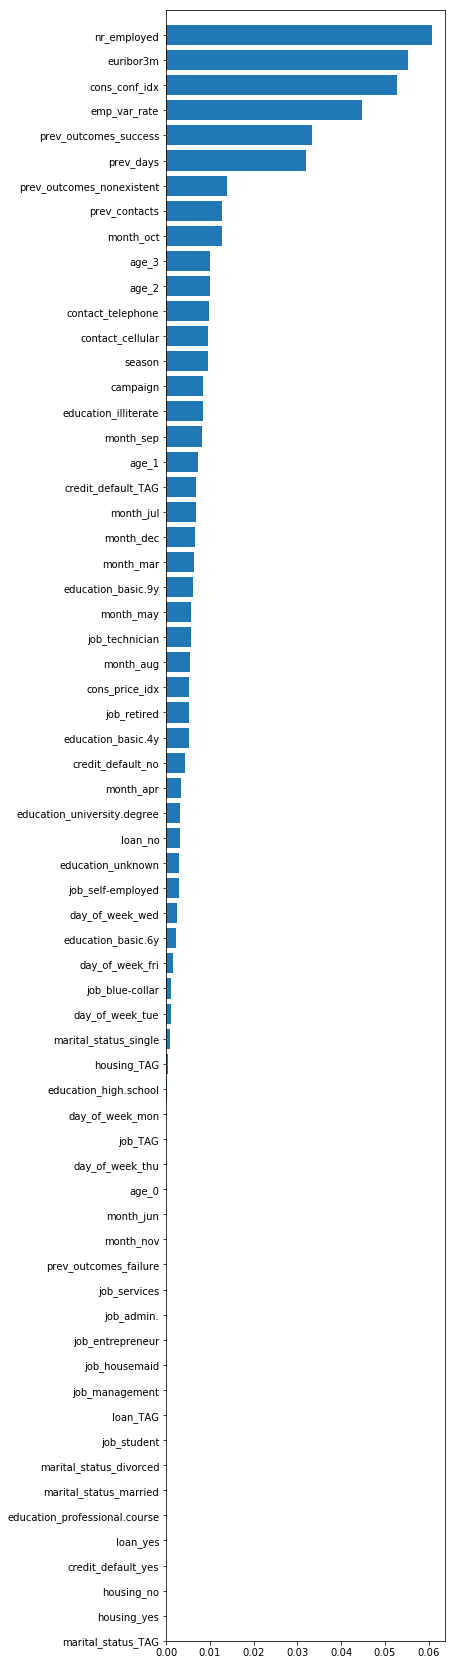

In [11]:
trainXCopy=trainX.copy()
trainXCopy['age']=trainXCopy['age'].astype('object')
#trainX.info()
trainXCopy=pd.get_dummies(trainXCopy)
imputer = DataFrameImputer()
XtrainImputed = imputer.fit_transform(trainXCopy)


from sklearn.feature_selection import mutual_info_regression
mi = mutual_info_regression(trainXCopy, trainY)
inds = np.argsort(mi)
plt.figure(figsize=(5, 30))
plt.barh(np.arange(len(mi)), np.log(mi[inds] + 1))
plt.yticks(np.arange(len(mi)), trainXCopy.columns[inds])
plt.ylim(0, len(mi))

In [12]:
split=0.4
X_train, X_test, y_train, y_test = train_test_split(trainX, trainY, 
                                                    test_size=split,
                                                    random_state=rng,
                                                   stratify=trainY)

print("\nTrain subscribed=1 ratio:",100*(y_train.sum()/y_train.shape[0])[0],"%")
print("\nTest subscribed=1 ratio:",100*(y_test.sum()/y_test.shape[0])[0],"%")

imputer = DataFrameImputer()
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

X_train=pd.get_dummies(X_train)
X_test=pd.get_dummies(X_test)

print("Train Shape:", X_train.shape)
print("Test Shape:", X_test.shape)


Train subscribed=1 ratio: 11.2645422357 %

Test subscribed=1 ratio: 11.2670713202 %
Train Shape: (19770, 62)
Test Shape: (13180, 62)


In [13]:
##using  grid search to learn best params for KNN
np.random.seed(seed)
param_grid = {'n_neighbors': range(1,20,5)}
gridKN = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, cv=5);
gridKN.fit(X_train, y_train['subscribed'])


GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': range(1, 20, 5)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

### MODEL SELECTION
For the purpose of selecting non tree based models for final ensemble,we looked at many classifiers.

1) KNeighborsClassifier

2) GaussianNB

3) LinearDiscriminantAnalysis

4) MLPClassifier

5) LogisticRegression

As seen in cross validation results,KNN gave good accuraccy but very low ROC with various parameter tuning.LDA and logistic gave decent results.

For the purpose of the ensemble model at the end,we have chose logistic and gaussian naive bayes.GNB does not have the best score here,but when present in voting classifier,it gave good results.

Also we have commented out grid search on MLPClassifier due to long running time.That said,it did not add any significat value to our model.


In [14]:
###HAD TO COMMENT OUT DUE TO LONG RUN
param_grid = {'alpha': np.arange(0.1,5,0.1)}
gridMLP = GridSearchCV(MLPClassifier(), param_grid=param_grid, cv=5);
#gridMLP.fit(X_train, y_train['subscribed'])
##Best param=.4


In [15]:
print("Best KNeighborsClassifier Param n_neighbors : ", gridKN.best_params_['n_neighbors'])
classifiers=[
            KNeighborsClassifier(n_neighbors=gridKN.best_params_['n_neighbors']),
            GaussianNB(),
            LinearDiscriminantAnalysis(),
            #MLPClassifier(alpha=gridMLP.best_params_['alpha']),
            LogisticRegression()
            ]

for clf in classifiers:
        clf.fit(X_train, y_train)
        name = clf.__class__.__name__

        print("="*30)
        print(name)

        print('****Results****')
        train_predictions = clf.predict(X_test)
        train_predicproba = clf.predict_proba(X_test)[:,1]
        acc = accuracy_score(y_test, train_predictions)
        roc= roc_auc_score(y_test['subscribed'], train_predicproba)
        
        crossvalscore=cross_val_score(clf, X_train, y_train['subscribed'], cv=10, scoring='f1') ## without Scaling
        
        print("Accuracy: {:.4%}".format(acc))  
        print("ROC Accuracy: {:.4%}".format(roc))  
        print("cross validation: %0.2f (+/- %0.2f)" % (crossvalscore.mean(), 
                                                       crossvalscore.std() * 2))
        print("="*30)
    

Best KNeighborsClassifier Param n_neighbors :  16
KNeighborsClassifier
****Results****
Accuracy: 89.6282%
ROC Accuracy: 77.7096%
cross validation: 0.35 (+/- 0.04)
GaussianNB
****Results****
Accuracy: 83.4977%
ROC Accuracy: 78.3586%
cross validation: 0.41 (+/- 0.05)
LinearDiscriminantAnalysis
****Results****
Accuracy: 89.0440%
ROC Accuracy: 79.5715%
cross validation: 0.43 (+/- 0.05)
LogisticRegression
****Results****
Accuracy: 90.0076%
ROC Accuracy: 79.8022%
cross validation: 0.33 (+/- 0.05)


# Step3 - ModelSet2


### Feature Engineering

1) Drop duration feature from use

2) We found out after multiple trials and error that unknown themselves behave as category.Hence we attempted to learn model parameters with and without imputing them.

3) Also we tried derived new features from existing features-such as attaching season from months after learning relatship shown in the plots above.

4) Bin features such as prev_days,emp_var,campaign,employees etc. into approriate columns.

5) After this we were as such left with only handful continuous columns.

6) We also tested various scaling techniques such as - minmax scaler,standard scalre and crossvalidated results.It appearsed that Min max scaler gave best results.




### Feature selection
Here we attempted to learn some mutual info score and apply feature selection.We tried using feature selection for top 10 features(['age','job','credit_default','contact','month','campaign','prev_contacts','prev_outcomes','emp_var_rate','nr_employed','euribor3m','cons_conf_idx']) but later only it only brought down the ROc-so low that in an attempted submission is was below first benchmark!

* Our learning also prompted us to revisit teh way we were loading data hence the redefinition of certain functions above.

### MODEL SELECTION
For the purpose of selecting non tree based models for final ensemble,we looked at many classifiers.

1) GradientBoostingClassifier
2) AdaBoostClassifier
3) RandomForestClassifier
4) DecisionTreeClassifier
5) ExtraTreesClassifier

In this section,we tested various tree based models and boosting techniques.Our learning on best params selected based on CV scores suggested that except for decision trees,these techniques give similar results.

For the purpose of ensemble model,we actually tried running each of these along with ExtraTreesClassifier that run on decision trees which gave us significant results.

CV results reported in following cells.


In [16]:
np.random.seed(seed)
param_grid = {'max_depth': range(1,20,2)}
gridDT = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid, cv=5);
gridDT.fit(X_train, y_train['subscribed'])
print("Best DecisionTreeClassifier Param max_depth: ", gridDT.best_params_['max_depth'])

Best DecisionTreeClassifier Param max_depth:  3


In [17]:
np.random.seed(seed)
param_grid = {'n_estimators': range(1,20,2)}
gridRF = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=5);
gridRF.fit(X_train, y_train['subscribed'])
print("Best RandomForestClassifier Param n_estimators: ", gridRF.best_params_['n_estimators'])  



Best RandomForestClassifier Param n_estimators:  13


#### Note that below,the classifiers have been further manually tuned to give better results.we have only put in teh best parameters selected here along with their CV scores!

In [18]:
classifiers=[GradientBoostingClassifier(n_estimators =20,
                                     learning_rate=0.1,
                                     max_depth=3,subsample=0.9,random_state=20),
            AdaBoostClassifier(n_estimators=270,random_state=10),
            RandomForestClassifier(n_estimators=180,
                                       max_depth=8,
                                       random_state=20),
            ExtraTreesClassifier(n_estimators=100, max_depth=7,
                                               min_samples_split=2, 
                                               random_state=20),
             DecisionTreeClassifier(max_depth=gridDT.best_params_['max_depth'])
            ]
for clf in classifiers:
        clf.fit(X_train, y_train)
        name = clf.__class__.__name__

        print("="*30)
        print(name)

        print('****Results****')
        train_predictions = clf.predict(X_test)
        train_predicproba = clf.predict_proba(X_test)[:,1]
        acc = accuracy_score(y_test, train_predictions)
        roc= roc_auc_score(y_test['subscribed'], train_predicproba)
        
        #crossvalscore=cross_val_score(clf, X_train, y_train['subscribed'], cv=10, scoring='f1') ## without Scaling
        
        print("Accuracy: {:.4%}".format(acc))  
        print("ROC Accuracy: {:.4%}".format(roc))  
        #print("cross validation: %0.2f (+/- %0.2f)" % (crossvalscore.mean(),crossvalscore.std() * 2))
        print("="*30)
    

GradientBoostingClassifier
****Results****
Accuracy: 90.0000%
ROC Accuracy: 79.5952%
AdaBoostClassifier
****Results****
Accuracy: 89.9621%
ROC Accuracy: 79.8384%
RandomForestClassifier
****Results****
Accuracy: 89.9469%
ROC Accuracy: 79.9213%
ExtraTreesClassifier
****Results****
Accuracy: 89.9317%
ROC Accuracy: 80.0134%
DecisionTreeClassifier
****Results****
Accuracy: 89.9697%
ROC Accuracy: 76.0215%


# Step4 - Ensemble 



### Ensemble 1-ExtraTreesClassifier

Here we learnt ExtraTreesClassifier using the best params learnt for decision tree.Infact this was the entry that hgave us significant gain both in ROC and also on public leadbord.

In [19]:
clf=ExtraTreesClassifier(n_estimators=100, max_depth=7,
                                               min_samples_split=2, 
                                               random_state=20)
clf.fit(X_train, y_train)
name = clf.__class__.__name__

print("="*30)
print(name)

print('****Results****')
train_predictions = clf.predict(X_test)
train_predicproba = clf.predict_proba(X_test)[:,1]
acc = accuracy_score(y_test, train_predictions)
roc= roc_auc_score(y_test['subscribed'], train_predicproba)

#crossvalscore=cross_val_score(clf, X_train, y_train['subscribed'], cv=10, scoring='f1') ## without Scaling

print("Accuracy: {:.4%}".format(acc))  
print("ROC Accuracy: {:.4%}".format(roc))  
#print("cross validation: %0.2f (+/- %0.2f)" % (crossvalscore.mean(),crossvalscore.std() * 2))
print("="*30)

ExtraTreesClassifier
****Results****
Accuracy: 89.9317%
ROC Accuracy: 80.0134%


### Ensemble 2 - Voting classifiers

1) Here we used a voting classifier with additional parameter tuning.Again it returned good ROC scores and returned good ROC scores as reported below.

2) Below are two of the many attempts with voting classifier.Note that we also tried a roue where we did not perform any feature selection but just applied min max scaler on continuous variables and one hot encoding on categoriacal variables with unknown appearing as a new category and not a missing value.

3) Voting classifier1- Logistic regression,GaussianNB,GradientBoostingClassifier,ExtraTreeClassifier with variable weights.

4) Additionally we also tried inclusing imbalanced learning-using over sampling and under sampling but results only worsened.We have keept the pipeline for make_imb_pipeline intact.

In [20]:
trainX,trainY, train=Main("data/data.csv")
holdoutTrain, holdoutID, holdout = Main("data/holdout.csv")

trainX=pd.get_dummies(trainX)
holdoutTrain=pd.get_dummies(holdoutTrain)
del trainX['credit_default_yes']

split=0.3
X_train, X_test, y_train, y_test = train_test_split(trainX, trainY, 
                                                    test_size=split,
                                                    random_state=rng,
                                                   stratify=trainY)

print("\ntest:",((y_test.sum())/(y_test.shape[0]))[0])
print("\ntrain:",((y_train.sum())/(y_train.shape[0]))[0])

scale = MinMaxScaler()

from sklearn.ensemble import ExtraTreesClassifier
np.random.seed(seed)
lr = LogisticRegression(random_state=rng)
gnb = GaussianNB()
boost=GradientBoostingClassifier(n_estimators =185)
ada=AdaBoostClassifier(n_estimators=270)
randomforestBest=RandomForestClassifier(n_estimators=100,
                                       warm_start=False,
                                       verbose =False,
                                       max_depth=15,
                                       max_features=20)

extf=ExtraTreesClassifier(n_estimators=100, max_depth=7,
                                               min_samples_split=2, 
                                               random_state=0)
mlp=MLPClassifier(alpha=0.15),
eclf = VotingClassifier(estimators=[
                                    ('lr', lr),
                                     ('gnb', gnb), 
                                    ('boost', boost),
                                    ('extf',extf)
],
                        voting='soft',
                        weights=[15, 0, 15,10],##81.2582%
                        n_jobs=-1)
clf=eclf.fit(X_train, y_train)
rus = RandomUnderSampler(replacement=False)
pipe = make_imb_pipeline(scale,
                         RandomOverSampler(random_state=24),
                         eclf).fit(X_train, y_train)
print("finished fit")
test_predicted=pipe.predict(X_test)
print("finished predict")
clf_probab=pipe.predict_proba(X_test)[:,1]


acc = accuracy_score(y_test, test_predicted)
roc= roc_auc_score(y_test, clf_probab)

print("Accuracy: {:.4%}".format(acc))  
print("ROC Accuracy: {:.4%}".format(roc)) 



test: 0.112696004047

train: 0.112638196401
finished fit
finished predict
Accuracy: 82.9843%
ROC Accuracy: 81.2173%


Voting classifier2- Logistic regression, ExtraTreeClassifier taht intenally uses decision trees.

In [21]:
eclf = VotingClassifier(estimators=[
                                    ('lr', lr),
                                     ('gnb', gnb), 
                                    ('boost', boost),
                                    ('extf',extf)
],
                        voting='soft',
                        weights=[15, 0, 0,10],##81.2582%
                        n_jobs=-1)
clf=eclf.fit(X_train, y_train)
rus = RandomUnderSampler(replacement=False)
pipe = make_imb_pipeline(scale,
                         RandomOverSampler(random_state=24),
                         eclf).fit(X_train, y_train)
print("finished fit")
test_predicted=pipe.predict(X_test)
print("finished predict")
clf_probab=pipe.predict_proba(X_test)[:,1]


acc = accuracy_score(y_test, test_predicted)
roc= roc_auc_score(y_test, clf_probab)

print("Accuracy: {:.4%}".format(acc))  
print("ROC Accuracy: {:.4%}".format(roc)) 


finished fit
finished predict
Accuracy: 82.1447%
ROC Accuracy: 81.2304%


### ENSEMBLE 3-StackingClassifier

In [22]:

sclf = StackingClassifier(classifiers=[gnb, boost, extf], 
                          meta_classifier=lr)
                          

clf=sclf.fit(X_train, y_train)
rus = RandomUnderSampler(replacement=False)
pipe = make_imb_pipeline(scale,
                         RandomOverSampler(random_state=24),
                         eclf).fit(X_train, y_train)
print("finished fit")
test_predicted=pipe.predict(X_test)
print("finished predict")
clf_probab=pipe.predict_proba(X_test)[:,1]


acc = accuracy_score(y_test, test_predicted)
roc= roc_auc_score(y_test, clf_probab)

print("Accuracy: {:.4%}".format(acc))  
print("ROC Accuracy: {:.4%}".format(roc)) 



finished fit
finished predict
Accuracy: 82.1447%
ROC Accuracy: 81.2304%


# FINAL MODEL

In [23]:
def getData(file):
    df = pd.read_csv(file,header=0)#, na_values=['unknown',999])
    if file == "data/data.csv":
        df['subscribed']=df['subscribed'].replace('yes',1,regex=True)
        df['subscribed']=df['subscribed'].replace('no',0,regex=True)
    
#     df['education']=df['education'].replace('basic.4y',"basic",regex=True)
#     df['education']=df['education'].replace('basic.6y',"basic",regex=True)
#     df['education']=df['education'].replace('basic.9y',"basic",regex=True)
#     df["campaign"].ix[df["campaign"]>15]=15
    df["prev_contacts"].ix[df["prev_contacts"]>6]=6
    
#     df.prev_days=df.prev_days.replace(np.nan,0,regex=True)
#     del df['prev_days']
    del df['duration']
    return df

 
def splitTargetAndPredictors(df,targetColumn):
    '''seperate the response variable'''
    targetDf=pd.DataFrame(df[targetColumn])
    del df[targetColumn]
    return df,targetDf

def binColumns(df):
    threshold = 10
    prevbins = [1, threshold,2*threshold,3*threshold]
#     df.prev_days=df.prev_days.replace(999,0,regex=True)
    x = np.array(df.prev_days)
    df.prev_days = (np.digitize(x,prevbins))#.astype(object)
#     df.prev_days=df.prev_days.replace(4,np.nan,regex=True)

#     prevcon = np.arange(1,7,2)
#     x = np.array(df.prev_contacts)
#     df.prev_contacts = (np.digitize(x,prevcon))#.astype(object)
    
    euro = np.arange(0.5,5.5,0.2)
    x = np.array(df.euribor3m)
    df.euribor3m = (np.digitize(x,euro))#.astype(object)

    empvar = np.arange(-3.5,1.8,1)
    x = np.array(df.emp_var_rate)
    df.emp_var_rate = (np.digitize(x,empvar))#.astype(object)
    
    consf = np.arange(-50,-25,0.5)
    x = np.array(df.cons_conf_idx)
    df.cons_conf_idx = (np.digitize(x,consf))#.astype(object)
    
    consp = np.arange(90,100,1)
    x = np.array(df.cons_price_idx)
    df.cons_price_idx = (np.digitize(x,consp))#.astype(object)
        
    ageBins = [21,62,81]
    x = np.array(df.age)
    df.age = (np.digitize(x,ageBins))#.astype(object)
    
    camp = np.arange(1,56,10)
    x = np.array(df.campaign)
    df.campaign = (np.digitize(x,camp))#astype(object)
   
    emplBins = np.arange(5000,5250,18)
    x = np.array(df.nr_employed)
    df.nr_employed=np.digitize(x,emplBins)#.astype(object)
    
    
    return df
    
def addFeatures(df):
    df.loc[(df['month']=='mar')|(df['month']=='apr')|(df['month']=='may'),"season"]=1#"spring"
    df.loc[(df['month']=='jun')|(df['month']=='jul')|(df['month']=='aug'),"season"]=2#"summer"
    df.loc[(df['month']=='sep')|(df['month']=='oct')|(df['month']=='nov'),"season"]=3#"fall"
    df.loc[(df['month']=='dec')|(df['month']=='jan')|(df['month']=='feb'),"season"]=4#"winter"
    return df

def Plot(df,cat = "category"):
     
    if cat == "cagetory":
        fig_size = plt.rcParams["figure.figsize"]
        fig_size[0] = 14
        fig_size[1] = 8
        cols = [col for col in df.columns if col not in Continuous_cols and col!="subscribed"]
        for col in cols:
            ptl = df.groupby([col])['subscribed'].mean()
            ptl = pd.DataFrame(ptl,index=df[col].unique())
            ptl = ptl.sort("subscribed")
            ptl.plot.barh()
            plt.title(col+ " vs subscribed")
    else:
        fig_size = plt.rcParams["figure.figsize"]
        fig_size[0] = 14
        fig_size[1] = 8
        
        cols = [col for col in df.columns if col in Continuous_cols and col!="subscribed"]

        for col in cols:
            ptl = df.groupby([col])['subscribed'].mean()
            ptl = pd.DataFrame(ptl)
            ptl.plot(color='r')
            if col == "campaign":
                plt.xticks(np.arange(0,16,2))
            plt.title(col+ " vs subscribed")
    return None

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

def Main(file):
    df=getData(file)
    df=addFeatures(df)
    df.season =df.season.astype(object)
    df=binColumns(df)
    df=imputeDF(df)
#     for col in ColDel:
#         del df[col]
    if file == "data/data.csv":
        trainX,trainY=splitTargetAndPredictors(df.copy(),'subscribed')
        return trainX, trainY, df
    else:
        holdout,holdoutID=splitTargetAndPredictors(df.copy(),'ID')
        return holdout, holdoutID, df
    
def replaceTag(df):
    df=df.replace(99999,np.nan,regex=True)
    df['age']=df['age'].astype('object')
    return df
    
def imputeDF(df):
    df.job = df.job.replace('unknown','admin.',regex=True)
    df.marital_status = df.marital_status.replace('unknown','married',regex=True)
    df.education = df.education.replace('unknown','basic.9y',regex=True)

    df.prev_days = df.prev_days.replace(999,0,regex=True)

    df.housing = df.housing.replace('unknown','yes',regex=True)
    df.loan = df.loan.replace('unknown','no',regex=True)
    
    return df
    
print("Functions Loaded!")




Functions Loaded!


In [24]:
split=0.25
seed = 0

In [25]:
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Data Type YPRED 1~~~~~~~~~~~~~~~~~~~~~~~~~~~
## Getting the data after some cleaning ##

dfx,dfy, train=Main("data/data.csv")
hold, holdID, holdout = Main("data/holdout.csv")

dfx=pd.get_dummies(dfx)
hold=pd.get_dummies(hold)
del dfx['credit_default_yes']


X_train, X_test, y_train, y_test = train_test_split(dfx, dfy, 
                                                    test_size=split,
                                                    random_state=seed,
                                                   stratify=dfy)

In [26]:
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Data Type YPRED 2~~~~~~~~~~~~~~~~~~~~~~~~~~~
## Getting the cleaned data and selecting some good features (features were selected based on their overall performance 
## cross validation on the model)
GoodFeatures = ['age','job','credit_default','contact','month','campaign','prev_contacts','prev_outcomes','emp_var_rate',
               'nr_employed','euribor3m','cons_conf_idx']

dfx2,dfy2, train2=Main("data/data.csv")
hold2, holdID, holdout2 = Main("data/holdout.csv")
dfx2 = dfx2[GoodFeatures]
hold2 = hold2[GoodFeatures]


dfx2=pd.get_dummies(dfx2)
hold2=pd.get_dummies(hold2)
del dfx2['credit_default_yes']

X_train2, X_test2, y_train2, y_test2 = train_test_split(dfx2, dfy2, 
                                                    test_size=split,
                                                    random_state=seed,
                                                   stratify=dfy2)

In [27]:
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Data Type YPRED 3~~~~~~~~~~~~~~~~~~~~~~~~~~~
## Getting the raw data without cleaning. This is essentially useful for tree-based models.

df3 = pd.read_csv("data/data.csv")
df3['subscribed']=df3['subscribed'].replace('yes',1,regex=True)
df3['subscribed']=df3['subscribed'].replace('no',0,regex=True)

hold3 = pd.read_csv("data/holdout.csv")

dfy3 = df3['subscribed']
del df3['duration']
del df3['subscribed']
dfx3 = df3
del hold3['duration']
del hold3['ID']

dfx3 = pd.get_dummies(dfx3)
hold3 = pd.get_dummies(hold3)
del dfx3['credit_default_yes']


X_train3, X_test3, y_train3, y_test3 = train_test_split(dfx3, dfy3, 
                                                    test_size=split,
                                                    random_state=seed,
                                                   stratify=dfy3)

In [28]:
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Data Type YPRED 4~~~~~~~~~~~~~~~~~~~~~~~~~~~
## Getting the raw data without cleaning and subsetting it with some selected features.

df4 = pd.read_csv("data/data.csv")
df4['subscribed']=df4['subscribed'].replace('yes',1,regex=True)
df4['subscribed']=df4['subscribed'].replace('no',0,regex=True)

hold4 = pd.read_csv("data/holdout.csv")

dfy4 = df4['subscribed']
del df4['duration']
del df4['subscribed']
dfx4 = df4
del hold4['duration']
del hold4['ID']

GoodFeatures = ['age','job','credit_default','contact','month','campaign','prev_contacts','prev_outcomes','emp_var_rate',
               'nr_employed','euribor3m','cons_conf_idx']

dfx4 = dfx4[GoodFeatures]
hold4 = hold4[GoodFeatures]

dfx4 = pd.get_dummies(dfx4)
hold4 = pd.get_dummies(hold4)
del dfx4['credit_default_yes']

X_train4, X_test4, y_train4, y_test4 = train_test_split(dfx4, dfy4, 
                                                    test_size=split,
                                                    random_state=seed,
                                                   stratify=dfy4)

(0, 15)

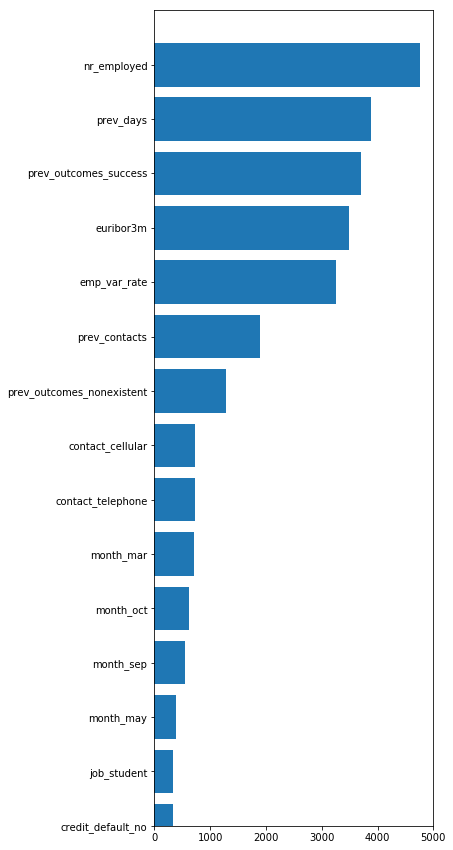

In [29]:
## We obtained some of the good features using f_regression rankings ##

F, p = f_regression(dfx3, dfy3)

top_n = 15
inds = np.argsort(F)
plt.figure(figsize=(5, 15))
plt.barh(np.arange(top_n), F[inds[-top_n:]])
plt.yticks(np.arange(top_n), dfx3.columns[inds[-top_n:]])
plt.ylim(0, top_n)



In [30]:
### Comparing DataSets and Tuning parameters that generated the best model ##
scale = MinMaxScaler()
# clf = GradientBoostingClassifier(random_state=34,n_estimators=230,max_depth=3,subsample=0.895,max_features=10)
# clf = RandomForestClassifier(random_state=0,n_estimators=220,max_features=5)
# clf = AdaBoostClassifier(random_state=34,n_estimators=138,learning_rate=0.6)
# clf = MLPClassifier(alpha=0.15,random_state=seed)

# for m in np.arange(0,50,1):
for m in np.arange(1):
    clf = GradientBoostingClassifier(random_state=34,n_estimators=231,
                                     max_depth=3,subsample=0.895,max_features=10)
#     clf = GradientBoostingClassifier(random_state=m,n_estimators=231,max_depth=3,subsample=0.895,max_features=10)

    
    gb = make_pipeline(scale,clf).fit(X_train,y_train)
    ypred = gb.predict_proba(X_test)[:,1]
    print("ypred:",m,"GB1:",100*roc_auc_score(y_test['subscribed'],ypred))
    
    gb2 = make_pipeline(scale,clf).fit(X_train2,y_train)
    ypred2 = gb2.predict_proba(X_test2)[:,1]
    print("ypred2:",m,"GB2:",100*roc_auc_score(y_test2['subscribed'],ypred2))

    gb3 = make_pipeline(scale,clf).fit(X_train3,y_train)
    ypred3 = gb3.predict_proba(X_test3)[:,1]
    print("ypred3:",m,"GB3:",100*roc_auc_score(y_test3,ypred3))

    gb4 = make_pipeline(scale,clf).fit(X_train4,y_train)
    ypred4 = gb4.predict_proba(X_test4)[:,1]
    print("ypred4:",m,"GB4:",100*roc_auc_score(y_test4,ypred4))



ypred: 0 GB1: 81.2845977405
ypred2: 0 GB2: 81.2970909595
ypred3: 0 GB3: 81.0210166163
ypred4: 0 GB4: 80.8442320392


In [31]:
### Comparing DataSets and Tuning parameters that generated the best model2 ##

scale = MinMaxScaler()
# clf = GradientBoostingClassifier(random_state=34,n_estimators=230,max_depth=3,subsample=0.895,max_features=10)
# clf = RandomForestClassifier(random_state=0,n_estimators=220,max_features=5)
# clf = AdaBoostClassifier(random_state=34,n_estimators=138,learning_rate=0.6)
# clf = MLPClassifier(alpha=0.15,random_state=seed)

del dfx3['cons_price_idx']
del hold3['cons_price_idx']

del dfx3['education_basic.6y']
del hold3['education_basic.6y']

del dfx3['education_basic.4y']
del hold3['education_basic.4y']

# for m in np.arange(0,50,1):
for m in np.arange(1):
    clf = GradientBoostingClassifier(random_state=34,n_estimators=231,max_depth=3,subsample=0.895,max_features=10)
#     clf = GradientBoostingClassifier(random_state=m,n_estimators=231,max_depth=3,subsample=0.895,max_features=10)

    
    gb = make_pipeline(scale,clf).fit(X_train,y_train)
    ypred = gb.predict_proba(X_test)[:,1]
    print("ypred:",m,"GB1:",100*roc_auc_score(y_test['subscribed'],ypred))
    
    gb2 = make_pipeline(scale,clf).fit(X_train2,y_train)
    ypred2 = gb2.predict_proba(X_test2)[:,1]
    print("ypred2:",m,"GB2:",100*roc_auc_score(y_test2['subscribed'],ypred2))

    gb3 = make_pipeline(scale,clf).fit(X_train3,y_train)
    ypred3 = gb3.predict_proba(X_test3)[:,1]
    print("ypred3:",m,"GB3:",100*roc_auc_score(y_test3,ypred3))

    gb4 = make_pipeline(scale,clf).fit(X_train4,y_train)
    ypred4 = gb4.predict_proba(X_test4)[:,1]
    print("ypred4:",m,"GB4:",100*roc_auc_score(y_test4,ypred4))



ypred: 0 GB1: 81.2845977405
ypred2: 0 GB2: 81.2970909595
ypred3: 0 GB3: 81.0210166163
ypred4: 0 GB4: 80.8442320392


## Cross Validation

In [32]:
df3 = pd.read_csv("data/data.csv")
df3['subscribed']=df3['subscribed'].replace('yes',1,regex=True)
df3['subscribed']=df3['subscribed'].replace('no',0,regex=True)

hold3 = pd.read_csv("data/holdout.csv")
holdID=hold3["ID"]
dfy3 = df3['subscribed']
del df3['duration']
del df3['subscribed']
dfx3 = df3
del hold3['duration']
del hold3['ID']

dfx3 = pd.get_dummies(dfx3)
hold3 = pd.get_dummies(hold3)
del dfx3['credit_default_yes'] ## removing this because holdout does not have this category

scale = MinMaxScaler()
# logpipe = make_pipeline(scale,LogisticRegressionCV())
# rf = make_pipeline(scale,RandomForestClassifier(random_state=rng,n_estimators=180,max_features=8))
# gs = make_pipeline(scale,GaussianNB())
gb = make_pipeline(scale,GradientBoostingClassifier(random_state=34,n_estimators=231,max_depth=3,subsample=0.895,max_features=10))

# print("LogReg:", 100*np.mean(cross_val_score(logpipe, dfx3, dfy3, cv = 5, scoring="roc_auc")))
# print("RF:",100*np.mean(cross_val_score(rf,  dfx3, dfy3, cv = 5, scoring="roc_auc")))
# print("GS:",100*np.mean(cross_val_score(gs,  dfx3, dfy3, cv = 5, scoring="roc_auc")))
print("GB:",100*np.mean(cross_val_score(gb, dfx3, dfy3, cv = 10, scoring="roc_auc")))


GB: 79.718319613


## Test
Here we assert that ROC score is greater than .81

In [33]:
def testFinal():
    split = 0.25
    seed = 0
    df3 = pd.read_csv("data/data.csv")
    df3['subscribed']=df3['subscribed'].replace('yes',1,regex=True)
    df3['subscribed']=df3['subscribed'].replace('no',0,regex=True)

    hold3 = pd.read_csv("data/holdout.csv")

    dfy3 = df3['subscribed']
    del df3['duration']
    del df3['subscribed']
    dfx3 = df3
    del hold3['duration']
    del hold3['ID']

    dfx3 = pd.get_dummies(dfx3)
    hold3 = pd.get_dummies(hold3)
    del dfx3['credit_default_yes']


    X_train3, X_test3, y_train3, y_test3 = train_test_split(dfx3, dfy3, 
                                                        test_size=split,
                                                        random_state=seed,
                                                       stratify=dfy3)

    scale = MinMaxScaler()
    clf = GradientBoostingClassifier(random_state=34,n_estimators=231,
                                     max_depth=3,subsample=0.895,max_features=10)

    gb3 = make_pipeline(scale,clf).fit(X_train3,y_train)
    ypred3 = gb3.predict_proba(X_test3)[:,1]
    print("ROC score:",100*roc_auc_score(y_test3,ypred3))
    assert((100*roc_auc_score(y_test3,ypred3) > 81.0),"Drop in ROC score")
    #print("ypred3:",m,"GB3:",100*roc_auc_score(y_test3,ypred3))


testFinal()


ROC score: 81.0210166163


## We selected 3rd type of loading the data based on overall cross validation scores and kaggle scores.
 3rd type of loading: load the data without much modification (no binning, imputation and other fancy pre-processing) and 
 no subsetting and then use gradientboostingclassifier

### Best Mode l - Kaggle Public Score : 0.78533 ###

After so many tries and Cross validation and feedback scores on Kaggle, we selected to use data from 3rd load - meaning, 
we load the data without cleaning and without removing any features (except for the prohibited features such as duration
and subscribed)



In [34]:

df3 = pd.read_csv("data/data.csv")
df3['subscribed']=df3['subscribed'].replace('yes',1,regex=True)
df3['subscribed']=df3['subscribed'].replace('no',0,regex=True)

hold3 = pd.read_csv("data/holdout.csv")
holdID=hold3["ID"]
df3y = df3['subscribed']
del df3['duration']
del df3['subscribed']
dfx3 = df3
del hold3['duration']
del hold3['ID']

dfx3 = pd.get_dummies(dfx3)
hold3 = pd.get_dummies(hold3)
del dfx3['credit_default_yes'] ## removing this because holdout does not have this category

scale = MinMaxScaler()

clf = GradientBoostingClassifier(random_state=34,n_estimators=231,max_depth=3,subsample=0.895,max_features=10)


pipe = make_pipeline(scale, clf).fit(dfx3,df3y)
y_pred = pipe.predict_proba(hold3)[:,1]
# y_pred = pipe.predict(hold3)

out_df = pd.DataFrame(y_pred)

out_df["ID"] = holdID
out_df.columns = ["subscribed", "ID"]
#out_df.to_csv("predictproba.csv", columns=["ID","subscribed"],index=False)    



### Best Model 2 - Kaggle Public Score : 0.78382 ###

After so many tries and Cross validation and feedback scores on Kaggle, we selected to use data from 3rd load - meaning, 

we load the data without cleaning and without removing any features (except for the prohibited features such as duration
and subscribed)



In [35]:
df3 = pd.read_csv("data/data.csv")
df3['subscribed']=df3['subscribed'].replace('yes',1,regex=True)
df3['subscribed']=df3['subscribed'].replace('no',0,regex=True)

hold3 = pd.read_csv("data/holdout.csv")
holdID=hold3["ID"]
df3y = df3['subscribed']
del df3['duration']
del df3['subscribed']
dfx3 = df3
del hold3['duration']
del hold3['ID']

dfx3 = pd.get_dummies(dfx3)
hold3 = pd.get_dummies(hold3)
del dfx3['credit_default_yes'] ## removing this because holdout does not have this category

scale = MinMaxScaler()


del dfx3['cons_price_idx']
del hold3['cons_price_idx']

del dfx3['education_basic.6y']
del hold3['education_basic.6y']

del dfx3['education_basic.4y']
del hold3['education_basic.4y']

clf = GradientBoostingClassifier(random_state=34,n_estimators=231,max_depth=3,subsample=0.895,max_features=10)


pipe = make_pipeline(scale, clf).fit(dfx3,df3y)
y_pred = pipe.predict_proba(hold3)[:,1]
# y_pred = pipe.predict(hold3)

out_df = pd.DataFrame(y_pred)

out_df["ID"] = holdID
out_df.columns = ["subscribed", "ID"]
#out_df.to_csv("predictproba.csv", columns=["ID","subscribed"],index=False)    



# Bonus: Resampling Techniques

Here we tried random over sampling and under sampling and scores are reported below (on a simple voting classifier).-We are reporting only one here
However the score is lower than our best score in above models hence we are not using it in final submission!

## ATTEMPT 1 -RandomOverSampling
We tried multiple parameters and reporting best here which performs worse that our final model

In [36]:
trainX,trainY, train=Main("data/data.csv")
holdoutTrain, holdoutID, holdout = Main("data/holdout.csv")

trainX=pd.get_dummies(trainX)
holdoutTrain=pd.get_dummies(holdoutTrain)
del trainX['credit_default_yes']

split=0.3
X_train, X_test, y_train, y_test = train_test_split(trainX, trainY, 
                                                    test_size=split,
                                                    random_state=rng,
                                                   stratify=trainY)

print("\ntest:",((y_test.sum())/(y_test.shape[0]))[0])
print("\ntrain:",((y_train.sum())/(y_train.shape[0]))[0])

scale = MinMaxScaler()

from sklearn.ensemble import ExtraTreesClassifier
np.random.seed(seed)
lr = LogisticRegression(random_state=rng)
gnb = GaussianNB()
boost=GradientBoostingClassifier(n_estimators =185)
ada=AdaBoostClassifier(n_estimators=270)
randomforestBest=RandomForestClassifier(n_estimators=100,
                                       warm_start=False,
                                       verbose =False,
                                       max_depth=15,
                                       max_features=20)

extf=ExtraTreesClassifier(n_estimators=100, max_depth=7,
                                               min_samples_split=2, 
                                               random_state=0)
mlp=MLPClassifier(alpha=0.15),
eclf = VotingClassifier(estimators=[
                                    ('lr', lr),
                                     ('gnb', gnb), 
                                    ('boost', boost),
                                    ('extf',extf)
],
                        voting='soft',
                        weights=[15, 0, 15,10],##81.2582%
                        n_jobs=-1)
clf=eclf.fit(X_train, y_train)
pipe = make_imb_pipeline(scale,
                         RandomOverSampler(random_state=24),
                         eclf).fit(X_train, y_train)
print("finished fit")
test_predicted=pipe.predict(X_test)
print("finished predict")
clf_probab=pipe.predict_proba(X_test)[:,1]


acc = accuracy_score(y_test, test_predicted)
roc= roc_auc_score(y_test, clf_probab)

print("Accuracy: {:.4%}".format(acc))  
print("ROC Accuracy: {:.4%}".format(roc)) 




test: 0.112696004047

train: 0.112638196401
finished fit
finished predict
Accuracy: 83.0956%
ROC Accuracy: 81.2904%


## ATTEMPT 2 -RandomUnderSampler
Agsin,we tried multiple parameters and reporting best here which performs worse that our final model

In [37]:
trainX,trainY, train=Main("data/data.csv")
holdoutTrain, holdoutID, holdout = Main("data/holdout.csv")

trainX=pd.get_dummies(trainX)
holdoutTrain=pd.get_dummies(holdoutTrain)
del trainX['credit_default_yes']

split=0.3
X_train, X_test, y_train, y_test = train_test_split(trainX, trainY, 
                                                    test_size=split,
                                                    random_state=rng,
                                                   stratify=trainY)

print("\ntest:",((y_test.sum())/(y_test.shape[0]))[0])
print("\ntrain:",((y_train.sum())/(y_train.shape[0]))[0])

scale = MinMaxScaler()

from sklearn.ensemble import ExtraTreesClassifier
np.random.seed(seed)
lr = LogisticRegression(random_state=rng)
gnb = GaussianNB()
boost=GradientBoostingClassifier(n_estimators =185)
ada=AdaBoostClassifier(n_estimators=270)
randomforestBest=RandomForestClassifier(n_estimators=100,
                                       warm_start=False,
                                       verbose =False,
                                       max_depth=15,
                                       max_features=20)

extf=ExtraTreesClassifier(n_estimators=100, max_depth=7,
                                               min_samples_split=2, 
                                               random_state=0)
mlp=MLPClassifier(alpha=0.15),
eclf = VotingClassifier(estimators=[
                                    ('lr', lr),
                                     ('gnb', gnb), 
                                    ('boost', boost),
                                    ('extf',extf)
],
                        voting='soft',
                        weights=[15, 0, 15,10],##81.2582%
                        n_jobs=-1)
clf=eclf.fit(X_train, y_train)
rus = RandomUnderSampler(replacement=False)
pipe = make_imb_pipeline(scale,
                         rus,
                         eclf).fit(X_train, y_train)
print("finished fit")
test_predicted=pipe.predict(X_test)
print("finished predict")
clf_probab=pipe.predict_proba(X_test)[:,1]


acc = accuracy_score(y_test, test_predicted)
roc= roc_auc_score(y_test, clf_probab)

print("Accuracy: {:.4%}".format(acc))  
print("ROC Accuracy: {:.4%}".format(roc)) 





test: 0.112696004047

train: 0.112638196401
finished fit
finished predict
Accuracy: 82.7516%
ROC Accuracy: 80.8903%
